# Exemplo de fMRI

Aqui, o objetivo é entender como funciona o pipeline de dados do exame para uma única amostra, desde o arquivo do exame de fMRI até a construção do grafo. Estaremos analisando o indivíduo com ID **0050642**, cujos dados foram coletados na **Carnegie Mellon University**.

### Funções de obtenção dos dados

In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [8]:
if is_colab():
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def get_data_path():
    if is_colab():
        return '/content/drive/MyDrive/IC/ABIDE I/fmri_CMU_A_ABIDE_0050642.nii.gz'
    else:
        return 'project_data/fmri_CMU_A_ABIDE_0050642.nii.gz'


In [3]:
def install_requirements_if_colab():
  if is_colab():
    !pip install git+https://github.com/matheo-angelo/IC/blob/main/requirements.txt
    !pip install -r requirements.txt

# Visualizando um exame fMRI

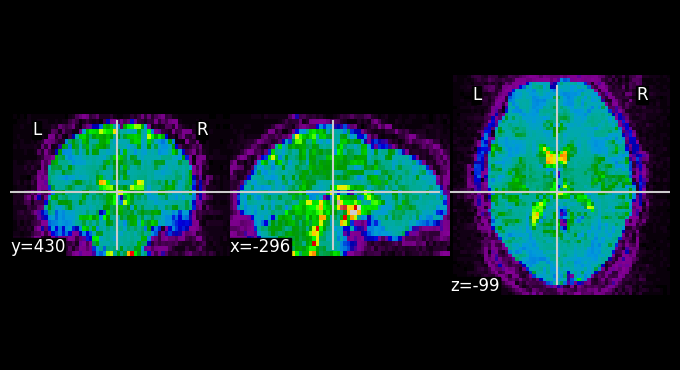

In [9]:
#install_requirements_if_colab()

from nilearn import image, plotting
import nibabel as nib

img = nib.load(get_data_path())
exame = img.get_fdata()

# Seleciona o primeiro tempo
first_timepoint = exame[:, :, :, 0]  # O primeiro tempo

# Cria uma nova imagem NIfTI a partir do primeiro tempo
first_timepoint_img = nib.Nifti1Image(first_timepoint, img.affine)

# Plota a imagem
plotting.plot_epi(first_timepoint_img)
plotting.show()

In [10]:
print(exame.shape)
print(first_timepoint_img.shape)

(64, 64, 28, 240)
(64, 64, 28)


In [11]:
import numpy as np

print("Valor mínimo: ", np.min(exame))
print("Valor máximo: ", np.max(exame))

Valor mínimo:  0.0
Valor máximo:  2033.0


# Atlas do cérebro

In [12]:
from nilearn import datasets

atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
atlas_img = nib.load(atlas.filename)
atlas_data = atlas_img.get_fdata()

print(atlas_data.shape)


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/fsl



Downloaded 22265856 of 25716861 bytes (86.6%,    0.2s remaining) ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/7311eb6e2a75d5a4596a018fd2af9a77/HarvardOxford.tgz...

(182, 218, 182)


.. done.


In [14]:
import numpy as np
from scipy.ndimage import zoom
from scipy.stats import mode

# Criar uma cópia do exame para evitar alterações no original
exame_substituto = exame.copy()
if exame_substituto.ndim == 4:
    exame_substituto = np.mean(exame_substituto, axis=-1)

# Defina a forma do fMRI e do atlas
fmri_shape = exame_substituto.shape
atlas_shape = atlas_data.shape

# Calcular os fatores de zoom para redimensionar o atlas
zoom_factors = [fmri_shape[i] / atlas_shape[i] for i in range(3)]

# Redimensionar o atlas com interpolação de moda
# Crie um novo array para armazenar os dados do atlas redimensionado
new_atlas_data = np.zeros(fmri_shape, dtype=int)

# Percorrer cada voxel do novo atlas
for x in range(fmri_shape[0]):
    for y in range(fmri_shape[1]):
        for z in range(fmri_shape[2]):
            # Calcular a região correspondente no atlas redimensionado
            orig_x = int(x / zoom_factors[0])
            orig_y = int(y / zoom_factors[1])
            orig_z = int(z / zoom_factors[2])

            # Coletar uma janela ao redor do voxel para calcular a moda
            values = atlas_data[
                max(0, orig_x - 1):min(atlas_shape[0], orig_x + 2),
                max(0, orig_y - 1):min(atlas_shape[1], orig_y + 2),
                max(0, orig_z - 1):min(atlas_shape[2], orig_z + 2)
            ].flatten()

            # Calcular a moda ignorando zeros (background)
            mode_value = mode(values[values != 0])  # Ignora voxels de fundo se necessário
            if mode_value.count > 0:  # Verifica se há uma moda válida
                new_atlas_data[x, y, z] = mode_value.mode
            else:
                new_atlas_data[x, y, z] = 0  # Se não houver moda, atribui 0 (fundo)

# Contagem de voxels por região
unique, counts = np.unique(new_atlas_data, return_counts=True)
voxel_counts = dict(zip(unique, counts))
print("Contagem de voxels por região:", voxel_counts)


Contagem de voxels por região: {0: 93941, 1: 2422, 2: 447, 3: 912, 4: 886, 5: 200, 6: 239, 7: 1348, 8: 762, 9: 100, 10: 155, 11: 137, 12: 436, 13: 331, 14: 109, 15: 321, 16: 243, 17: 1054, 18: 451, 19: 251, 20: 372, 21: 374, 22: 1448, 23: 668, 24: 215, 25: 150, 26: 217, 27: 197, 28: 413, 29: 408, 30: 382, 31: 830, 32: 195, 33: 500, 34: 239, 35: 137, 36: 523, 37: 91, 38: 268, 39: 225, 40: 312, 41: 111, 42: 273, 43: 173, 44: 123, 45: 81, 46: 156, 47: 34, 48: 828}


### Contagem de voxels de cada ROI

A função utilizada contém um atlas determinístico (ou seja, que faz a mesma divisão de regiões de interesse para qualquer exame fMRI) que parcela o exame em 48 regiões cerebrais diferentes, além da região externa ao cérebro.

In [15]:
_, contagens = np.unique(atlas_data, return_counts=True)
print(contagens)

[6166659  120948   21449   45246   45499    9503   11674   70031   37827
    4482    6488    6952   21879   16041    5385   15745   11973   55269
   23450   13831   18720   19542   78196   32849   11317    7796   11954
    9021   23252   20844   19228   44787    9934   25157    9956    5698
   26880    4901   12680   11759   14538    5313   14953    8739    5871
    4730    8032    2081   41973]


### Criando a Série Temporal de cada ROI

In [25]:
n_regions = len(np.unique(atlas_data))

# Inicializa o dicionário ou array para armazenar a série média de cada região
bold_series = {}

for region in range(1, n_regions):
    # Cria uma máscara para selecionar os voxels da região atual
    mask = (new_atlas_data == region)

    # Extrai as séries temporais dos voxels correspondentes na região atual
    # A máscara precisa ter as mesmas 3 primeiras dimensões que exame para indexação correta
    region_voxels = exame[mask]

    # Calcula a média ao longo dos voxels da região, mantendo a dimensão do tempo (última)
    m = np.mean(region_voxels, axis=0)

    # Armazena a série média para a região atual
    bold_series[region] = m


# Construindo o grafo

Inicialmente, iremos supor que os nós não têm features. (O código abaixo ainda não funciona)

In [33]:
import networkx as nx
from scipy.stats import pearsonr

grafo_cerebro = nx.Graph()
threshold = 0.7 # Limiar de correlação para conectar regiões do cérebro

for x in range(1,49):
    for y in range(x+1, 49):
        correlacao, _ = pearsonr(bold_series[x], bold_series[y])
        if correlacao > threshold:
            grafo_cerebro.add_edge(x, y)

Desenhando o grafo:

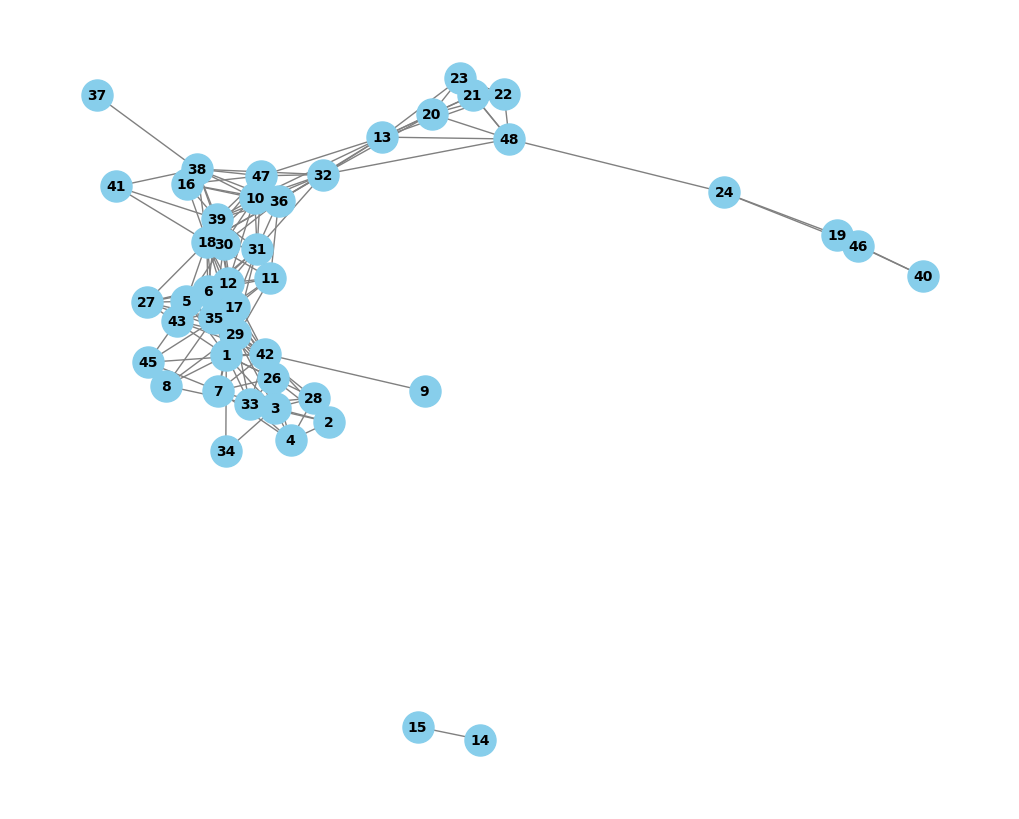

In [41]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10, 8))

# Usa o spring_layout com um parâmetro de repulsão maior
pos = nx.spring_layout(grafo_cerebro, seed=42, k=1.5/np.sqrt(len(grafo_cerebro.nodes())))

# Desenha o grafo com todos os nós e componentes próximos, mas sem sobreposição
nx.draw(
    grafo_cerebro,
    pos,
    with_labels=True,
    node_color="skyblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
    font_weight="bold"
)

plt.show()
